Cryptography with BB84 

https://github.com/qiskit-community/qiskit-community-tutorials/blob/master/awards/teach_me_qiskit_2018/cryptography/Cryptography.ipynb

In [1]:
import qiskit
# Import numpy for random number generation
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute, BasicAer

# Import basic plotting tools
from qiskit.tools.visualization import plot_histogram

Next we do some preliminary settings to better manipulate quantum circuits and we set the number of available (qu)bits to 16



In [3]:
# Creating registers with n qubits
n = 16  # for a local backend n can go as up as 23, after that it raises a Memory Error
qr = QuantumRegister(n, name='qr')
cr = ClassicalRegister(n, name='cr')

#We create Alice's quantum circuit, made of qubits (and bits in a classical register, for measuring). We use 
 from numpy to generate a random number in the available range which will be our key and then we write the resulted number in binary and we memorize the key in a proper variable

In [4]:
# Quantum circuit for alice state
alice = QuantumCircuit(qr, cr, name='Alice')

# Generate a random number in the range of available qubits [0,65536))
alice_key = np.random.randint(0, high=2**n)

# Cast key to binary for encoding
# range: key[0]-key[15] with key[15] least significant figure
alice_key = np.binary_repr(alice_key, n) # n is the width

In [5]:
# Encode key as alice qubits 
# IBM's qubits are all set to |0> initially
for index, digit in enumerate(alice_key):
    if digit == '1':
        alice.x(qr[index]) # if key has a '1', change state to |1>
        
# Switch randomly about half qubits to diagonal basis
alice_table = []        # Create empty basis table
for index in range(len(qr)):       # BUG: enumerate(q) raises an out of range error
    if 0.5 < np.random.random():   # With 50% chance...
        alice.h(qr[index])         # ...change to diagonal basis
        alice_table.append('X')    # character for diagonal basis
    else:
        alice_table.append('Z')    # character for computational basis

In [6]:
# get_qasm method needs the str label
# alternatively we can use circuits[0] but since dicts are not ordered
# it is not a good idea to put them in a func
# circuits = list(qp.get_circuit_names())

def SendState(qc1, qc2, qc1_name):
    ''' This function takes the output of a circuit qc1 (made up only of x and 
        h gates and initializes another circuit qc2 with the same state
    ''' 
    
    # Quantum state is retrieved from qasm code of qc1
    qs = qc1.qasm().split(sep=';')[4:-1]

    # Process the code to get the instructions
    for index, instruction in enumerate(qs):
        qs[index] = instruction.lstrip()

    # Parse the instructions and apply to new circuit
    for instruction in qs:
        if instruction[0] == 'x':
            old_qr = int(instruction[5:-1])
            qc2.x(qr[old_qr])
        elif instruction[0] == 'h':
            old_qr = int(instruction[5:-1])
            qc2.h(qr[old_qr])
        elif instruction[0] == 'm': # exclude measuring:
            pass
        else:
            raise Exception('Unable to parse instruction')

In [7]:
bob = QuantumCircuit(qr, cr, name='Bob')

SendState(alice, bob, 'Alice')    

# Bob doesn't know which basis to use
bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random():  # With 50% chance...
        bob.h(qr[index])        # ...change to diagonal basis
        bob_table.append('X')
    else:
        bob_table.append('Z')

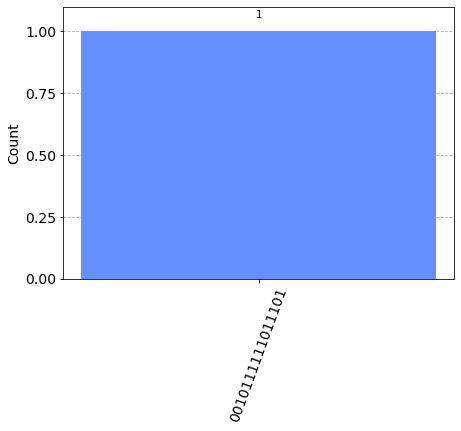

In [8]:
# Measure all qubits
for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])
    
# Execute the quantum circuit 
backend = BasicAer.get_backend('qasm_simulator')    
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))

In [9]:
# Result of the measure is Bob's key candidate
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]      # key is reversed so that first qubit is the first element of the list

In [10]:
keep = []
discard = []
for qubit, basis in enumerate(zip(alice_table, bob_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)

Same choice for qubit: 0, basis: Z
Different choice for qubit: 1, Alice has Z, Bob has X
Different choice for qubit: 2, Alice has X, Bob has Z
Different choice for qubit: 3, Alice has X, Bob has Z
Same choice for qubit: 4, basis: X
Different choice for qubit: 5, Alice has X, Bob has Z
Same choice for qubit: 6, basis: X
Same choice for qubit: 7, basis: Z
Same choice for qubit: 8, basis: X
Same choice for qubit: 9, basis: X
Different choice for qubit: 10, Alice has Z, Bob has X
Different choice for qubit: 11, Alice has X, Bob has Z
Different choice for qubit: 12, Alice has X, Bob has Z
Same choice for qubit: 13, basis: Z
Same choice for qubit: 14, basis: Z
Different choice for qubit: 15, Alice has Z, Bob has X


In [11]:
acc = 0
for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('Percentage of qubits to be discarded according to table comparison: ', len(keep)/n)
print('Measurement convergence by additional chance: ', acc/n)         

Percentage of qubits to be discarded according to table comparison:  0.5
Measurement convergence by additional chance:  0.6875


In [12]:
new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [bob_key[qubit] for qubit in keep]

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('Percentage of similarity between the keys: ', acc/len(new_alice_key))     

Percentage of similarity between the keys:  1.0


In [13]:
if (acc//len(new_alice_key) == 1):
    print("Key exchange has been successfull")
    print("New Alice's key: ", new_alice_key)
    print("New Bob's key: ", new_bob_key)
else:
    print("Key exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid: ", new_alice_key)
    print("New Bob's key is invalid: ", new_bob_key)

Key exchange has been successfull
New Alice's key:  ['1', '1', '1', '1', '1', '1', '1', '0']
New Bob's key:  ['1', '1', '1', '1', '1', '1', '1', '0']


In [14]:
eve = QuantumCircuit(qr, cr, name='Eve')
SendState(alice, eve, 'Alice')  

In [15]:
eve_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        eve.h(qr[index])        
        eve_table.append('X')
    else:
        eve_table.append('Z')

In [16]:
for index in range(len(qr)): 
    eve.measure(qr[index], cr[index])
    
# Execute (build and run) the quantum circuit 
backend = BasicAer.get_backend('qasm_simulator')    
result = execute(eve, backend=backend, shots=1).result()

# Result of the measure is Eve's key
eve_key = list(result.get_counts(eve))[0]
eve_key = eve_key[::-1]

In [17]:
# Update states to new eigenstates (of wrongly chosen basis)
for qubit, basis in enumerate(zip(alice_table, eve_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0]))
    else:
        print("Different choice for qubit: {}, Alice has {}, Eve has {}" .format(qubit, basis[0], basis[1]))
        if eve_key[qubit] == alice_key[qubit]:
            eve.h(qr[qubit])
        else:
            if basis[0] == 'X' and basis[1] == 'Z':
                eve.h(qr[qubit])
                eve.x(qr[qubit])
            else:
                eve.x(qr[qubit])
                eve.h(qr[qubit])

Same choice for qubit: 0, basis: Z
Different choice for qubit: 1, Alice has Z, Eve has X
Same choice for qubit: 2, basis: X
Same choice for qubit: 3, basis: X
Different choice for qubit: 4, Alice has X, Eve has Z
Different choice for qubit: 5, Alice has X, Eve has Z
Same choice for qubit: 6, basis: X
Different choice for qubit: 7, Alice has Z, Eve has X
Different choice for qubit: 8, Alice has X, Eve has Z
Different choice for qubit: 9, Alice has X, Eve has Z
Different choice for qubit: 10, Alice has Z, Eve has X
Different choice for qubit: 11, Alice has X, Eve has Z
Different choice for qubit: 12, Alice has X, Eve has Z
Different choice for qubit: 13, Alice has Z, Eve has X
Different choice for qubit: 14, Alice has Z, Eve has X
Same choice for qubit: 15, basis: Z


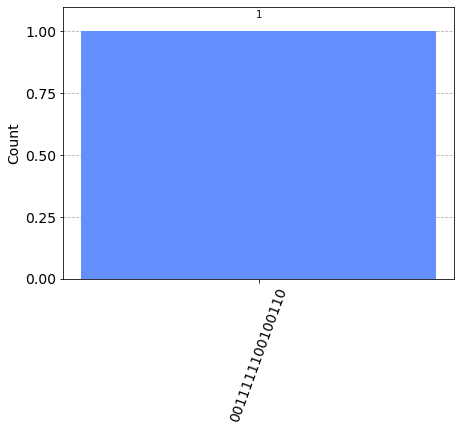

In [18]:
SendState(eve, bob, 'Eve')
          
bob_table = []
for index in range(len(qr)): 
    if 0.5 < np.random.random(): 
        bob.h(qr[index])      
        bob_table.append('X')
    else:
        bob_table.append('Z')
          
for index in range(len(qr)): 
    bob.measure(qr[index], cr[index])
          
result = execute(bob, backend=backend, shots=1).result()
plot_histogram(result.get_counts(bob))

In [19]:
bob_key = list(result.get_counts(bob))[0]
bob_key = bob_key[::-1]

In [20]:
keep = []
discard = []
for qubit, basis in enumerate(zip(alice_table, bob_table)):
    if basis[0] == basis[1]:
        print("Same choice for qubit: {}, basis: {}" .format(qubit, basis[0])) 
        keep.append(qubit)
    else:
        print("Different choice for qubit: {}, Alice has {}, Bob has {}" .format(qubit, basis[0], basis[1]))
        discard.append(qubit)
        
acc = 0
for bit in zip(alice_key, bob_key):
    if bit[0] == bit[1]:
        acc += 1

print('\nPercentage of qubits to be discarded according to table comparison: ', len(keep)/n)
print('Measurement convergence by additional chance: ', acc/n)  

new_alice_key = [alice_key[qubit] for qubit in keep]
new_bob_key = [bob_key[qubit] for qubit in keep]

acc = 0
for bit in zip(new_alice_key, new_bob_key):
    if bit[0] == bit[1]:
        acc += 1        
        
print('\nPercentage of similarity between the keys: ', acc/len(new_alice_key)) 

if (acc//len(new_alice_key) == 1):
    print("\nKey exchange has been successfull")
    print("New Alice's key: ", new_alice_key)
    print("New Bob's key: ", new_bob_key)
else:
    print("\nKey exchange has been tampered! Check for eavesdropper or try again")
    print("New Alice's key is invalid: ", new_alice_key)
    print("New Bob's key is invalid: ", new_bob_key)

Different choice for qubit: 0, Alice has Z, Bob has X
Different choice for qubit: 1, Alice has Z, Bob has X
Same choice for qubit: 2, basis: X
Same choice for qubit: 3, basis: X
Different choice for qubit: 4, Alice has X, Bob has Z
Different choice for qubit: 5, Alice has X, Bob has Z
Different choice for qubit: 6, Alice has X, Bob has Z
Different choice for qubit: 7, Alice has Z, Bob has X
Same choice for qubit: 8, basis: X
Same choice for qubit: 9, basis: X
Same choice for qubit: 10, basis: Z
Same choice for qubit: 11, basis: X
Different choice for qubit: 12, Alice has X, Bob has Z
Different choice for qubit: 13, Alice has Z, Bob has X
Same choice for qubit: 14, basis: Z
Same choice for qubit: 15, basis: Z

Percentage of qubits to be discarded according to table comparison:  0.5
Measurement convergence by additional chance:  0.6875

Percentage of similarity between the keys:  0.875

Key exchange has been tampered! Check for eavesdropper or try again
New Alice's key is invalid:  ['1',